In [1]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs

from vfm_reader import VfmReader
from frykit.calc import region_ind
import frykit.plot as fplt

plt.rcParams['font.family'] = 'Source Han Sans SC'
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# 读取文件.
dirpath = Path('../data')
filepath = dirpath / 'CAL_LID_L2_VFM-Standard-V4-21.2021-03-15T19-18-09ZN.hdf'
with VfmReader(filepath) as reader:
    lon = reader.lon
    lat = reader.lat
    time = reader.time
    height = reader.height
    fcf = reader.fcf

In [3]:
# 用地图显示范围截取数据.
extents = [100, 120, 30, 45]
scan_mask = region_ind(lon, lat, extents)
lon = lon[scan_mask]
lat = lat[scan_mask]
time = time[scan_mask]
fcf = fcf[scan_mask]
ftype = np.where(fcf[:, :, 0] == 3, fcf[:, :, 4], 0)

In [4]:
# 构造cmap和norm.
colors = [
    'white', 'blue', 'gold', 'red',
    'green', 'brown', 'black', 'gray'
]
ticklabels = [
    'not aerosol', 'clean\nmarine', 'dust', 'polluted\ncontinental',
    'clean\ncontinental', 'pullted\ndust', 'smoke', 'other'
]
cmap, norm, ticks = fplt.get_qualitative_palette(colors)

# 构造截面图所需的x轴刻度.
x, xticks, xticklabels = fplt.get_cross_section_xticks(lon, lat, ntick=5)

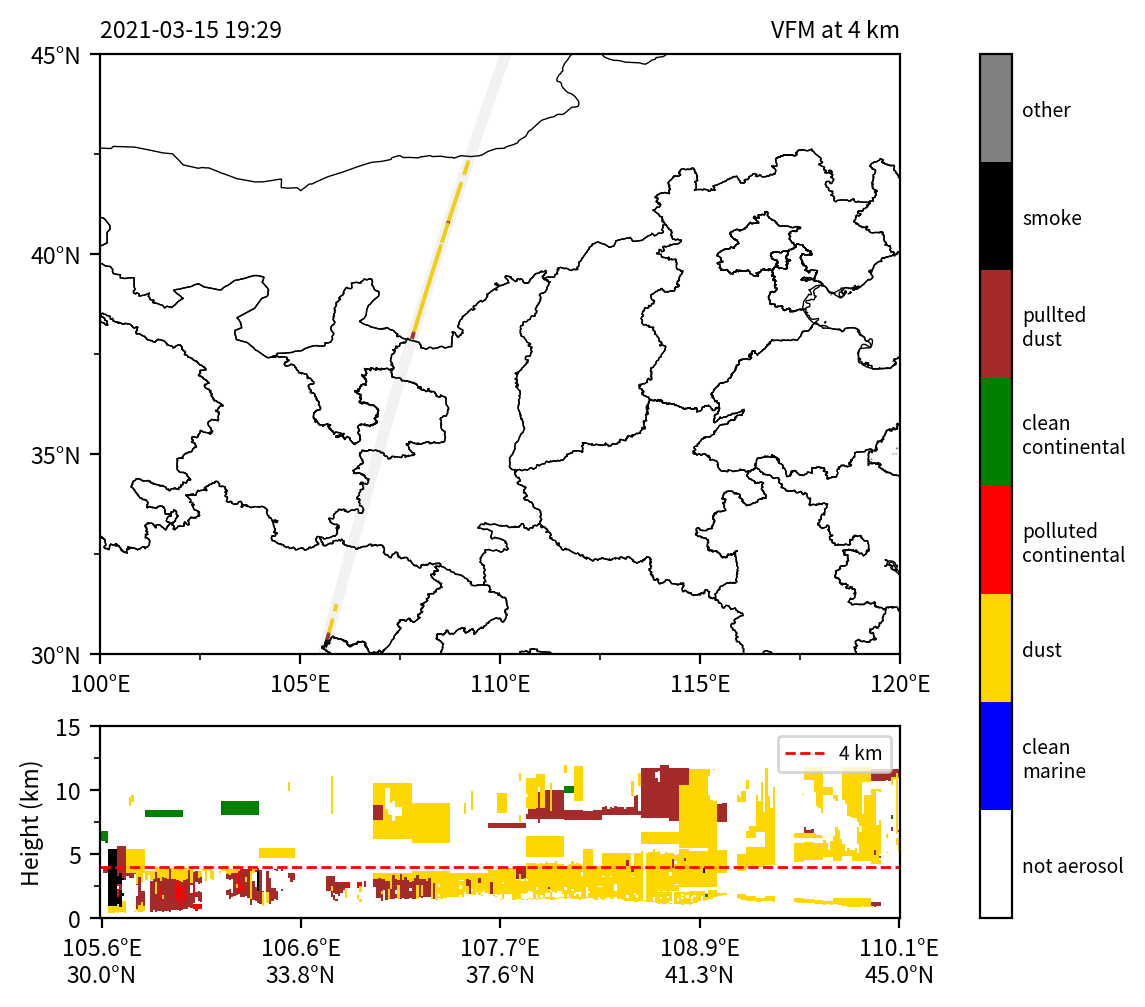

In [5]:
crs = ccrs.PlateCarree()
fig = plt.figure(figsize=(8, 6))

# 绘制地图.
ax1 = fig.add_axes([0.1, 0.4, 0.8, 0.5], projection=crs)
fplt.add_cn_province(ax1, lw=0.5)
ax1.coastlines(resolution='10m', lw=0.5)
fplt.set_map_ticks(ax1, extents, dx=5, dy=5, mx=1, my=1)
ax1.tick_params(labelsize='small')

# 画出VFM在h0高度的水平分布.
h0 = 4
ind = np.nonzero(height <= h0)[0][-1]
ax1.plot(lon, lat, lw=4, c='gray', alpha=0.1, transform=crs)
ax1.scatter(
    lon, lat, c=ftype[:, ind], s=0.2,
    cmap=cmap, norm=norm, transform=crs
)
mean_time = time.mean().strftime('%Y-%m-%d %H:%M')
ax1.set_title(mean_time, loc='left', fontsize='small')
ax1.set_title(f'VFM at {h0} km', loc='right', fontsize='small')

# 画出VFM的垂直剖面.
ax2 = fplt.add_side_axes(ax1, loc='bottom', pad=0.06, width=0.16)
pc = ax2.pcolormesh(x, height, ftype.T, cmap=cmap, norm=norm, shading='nearest')
ax2.axhline(h0, ls='--', c='r', lw=1, label=f'{h0} km')
ax2.legend(loc='upper right', fontsize='x-small')

# 设置ax2的坐标轴.
ax2.set_xticks(xticks)
ax2.set_xticklabels(xticklabels)
if filepath.stem[-1] == 'N':
    ax2.invert_xaxis()
ax2.set_ylim(0, 15)
ax2.set_ylabel('Height (km)', fontsize='small')
ax2.yaxis.set_major_locator(mticker.MultipleLocator(5))
ax2.yaxis.set_minor_locator(mticker.AutoMinorLocator(2))
ax2.tick_params(labelsize='small')

# 设置colorbar.
cax = fplt.add_side_axes([ax1, ax2], loc='right', pad=0.05, depth=0.02)
cbar = fig.colorbar(pc, cax=cax)
cbar.set_ticks(ticks)
cbar.set_ticklabels(ticklabels)
cbar.ax.tick_params(length=0, labelsize='x-small')